## What is Ensemble?

A supervised *meta*-learning algorithm: 
1. It uses multiple learners (also called estimators)
1. Combines them to produce *better* results

## How do they work?

We're going to say that F is a learner if, for given a training set, $ X = {(x_i, y_i) \in \mathbb{R}^n \times \mathbb{R}} $, F gives us an estimation, $f$, of the underlying distribution, $P$. 

In other words, $f:\mathbb{R}^n \rightarrow \mathbb{R}$ is our *predictor* or *model*, trained on $X$ using the learner $F$. Some examples of learners:
* Linear Regression: takes in $(x_i, y_i)$ pairs and outputs a predictor in the form $f(x) = \beta_0 + \beta_1\cdot x$. The *learning* consists in attempting to find $\beta$ such that the $L_2$ error norm is minimized over $X$.
* Multilayer Perceptron: takes in $(x_i, y_i)$ pairs and, for a given architecture of a network, $f$, tries to minimize some loss function over our training set.

Suppose you have several learners:
\begin{equation}
F_1, F_2, \ldots, F_k
\end{equation}

### How could you combine them to get something better?

There are essentially 3 ways in which to do this. 
1. Bagging: average them to reduce variance
1. Boosting: exploit inter-dependence
1. Stacking: combine them using another learner

## 1. Bagging

Bagging is short for bootstrap aggregation: 
1. Repeat the following m times:
    * Bootstrap your training set (i.e. take a sub-sample with replacement)
    * Train one of your learners on this sample, producing $f_i$
2. Combine all of your models into a single model:
\begin{equation}
f(x) = \frac{1}{m}\sum_{i = 1}^m {f_i(x)}
\end{equation}

Bagging can be used with any base learners. 
* It reduces variance
* Turns unstable learners (such as decision trees) into stable learners
* It does not help as much when the base learners are already stable

One example of a famous bagging technique is Random Forest. Let's see how it works:
1. Take as learner a Decision Tree - e.g. ID3. 
1. Repeat M times:
    * Generate a bagging sample, while also sampling the features
    * Train ID3 on it, producing one decision tree
1. The resulting model is the average of all the decision trees (for classification, you would use voting)

In [1]:
%matplotlib inline

import itertools

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

np.random.seed(0)

In [2]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
    
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)    

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]


NameError: name 'plot_decision_regions' is not defined

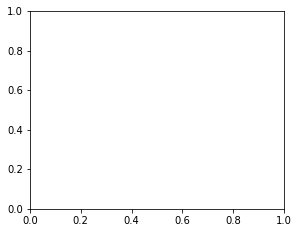

In [3]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

## 2. Boosting

Train learners one on top of the other:
1. Learn using the existing training set, where we weigh each sample identically
1. Repeat m times:
    * Weigh samples based on the current error so far
    * Apply a new learner to the weighted train set
1. Output as model the sum of all trained models

Boosting helps reduce bias, but increases variance:
* It works well with stable learners
* It converts weak learners into strong learners

The main differences between boosting and bagging:
1. Bagging trains in parallel. Boosting trains sequentially
1. Boosting exploits learner inter-dependence. Bagging exploits learner independence. 

One example of a famous boosting algorithm is Gradient Boosted Trees (with its commonly used implementation of XGBoost):
1. It tries to sequentially minimize the Loss function along its gradient (hence the name):
    * Loss function is $L(y, f(X))$
    * Iteratively, try to update your model by searching for:
\begin{equation}
f_m = f_{m-1} + argmin_{h_m} L(y, f_{m-1} + h_m)
\end{equation}
    * We decide to follow along the gradient of the loss function:
\begin{align}
    f_m = f_{m-1} - \gamma_m \cdot \nabla_{h_m} L(y, f_{m-1} + h_m)\\
\end{align}
1. When the loss is squared error (e.g. in regression), this just means trainign a new tree using the errors you have so far

In [6]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
    
#XOR dataset
#X = np.random.randn(200, 2)
#y = np.array(map(int,np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)))
    
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

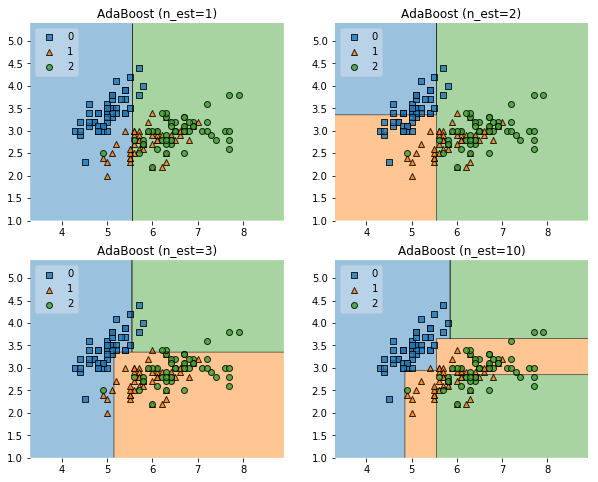

In [7]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

## 3. Stacking

Combines the two methods, using two levels:
1. First, train your base learners similarly to bagging, obtaining $f_1, f_2, \ldots, f_m$
1. Enrich your data with the predictions made by these base learners:
\begin{equation}
    x = (x^1,\ldots,x^d) \rightarrow (x^1,\ldots,x^d, f_1(x), f_2(x), \ldots, f_m(x))
\end{equation}
1. Apply another learner on top of the extended data

It's important to note:
1. The final learner will be able to compute the residuals (errors) for each base learner. 
1. It might decide to average several base learners for a prediction (bagging), or offset their prediction for several examples (boosting)

In [9]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)


Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.91 (+/- 0.06) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.03) [Stacking Classifier]


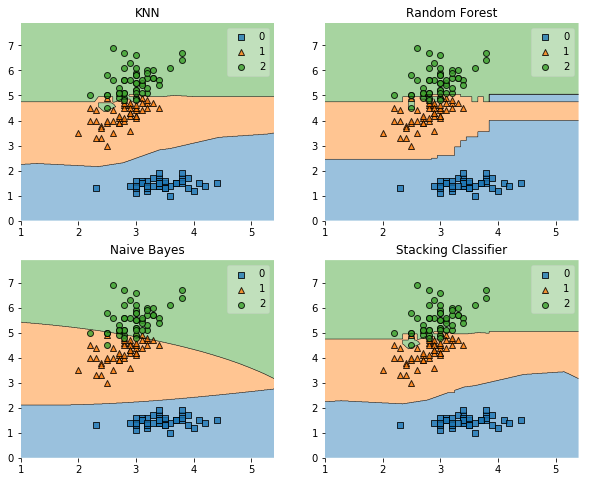

In [10]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()

## SuperLearner

There is an issue with all the algorithms presented thus far:
* All model errors get evaluated on the same data the model is trained
* This can be corrected somewhat through sub-sampling
* But sub-sampling reduces training set size, which means you loose on efficiency

The idea for SuperLearner was initially hinted at in van der Laan and Dudoit's 2003 paper and developed in van der Laan's 2007 paper (https://pdfs.semanticscholar.org/4e81/f4c95dde9a327026c584b91a3fe691595d1f.pdf). Essentially, it states that **cross-fold validation** gives a good estimate for the error, so let's use that.

1. We define the CrossFold Validation operator $CV_F$:
    * Do k-fold on X: $K = \{ (X_T^i, X_V^i)| X_T^i \cup X_V^i = X, X_T^i\cap X_V^i = 0 \}$ such that $\cup_i X_V^i = X$ and $X_V^i \cap X_V^j = 0$
    * Apply $F_i$ on $X_T^i$
    * Apply $f_i$ on $X_V^i$: $CV_F(x) = f_i(x)$ where $x\in X_V^i$
1. We enrich our data using the CV operator:
\begin{equation}
x = (x^1,\ldots,x^d) \rightarrow (x^1,\ldots,x^d, CV_{F_1}(x), CV_{F_2}(x), \ldots, CV_{F_m}(x))
\end{equation}
1. We train on top of this another model, also known as the meta-model, $mf$.
1. Apply each base learner on $X$ and produce $f_1, \ldots, f_m$.
1. Output the model 
\begin{equation}
f(x) = mf(x, f_1(x), \ldots, f_m(x))
\end{equation}

Van der Laan shows that SuperLearner behaves at worst as the best base learner. 

## Why should I use it?

**You need to use cross-fold validation anyway!!**
     
     * Any ML pipeline should contain a CV fold stage that searches for the *best* learner
     * You're already supposed to spend the resources on CV folding
     * SuperLearner will simply squeeze that extra performance from the base learners